In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# MAMGD Optimizer Class

Gradient optimization method using exponential damping and second-order discrete derivative for neural networks and multidimensional real functions

In [4]:
class MAMGD(keras.optimizers.Optimizer):
    def __init__(
        self,
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        k=0.00001,
        epsilon=1e-7,
        weight_decay=None,
        clipnorm=None,
        clipvalue=None,
        global_clipnorm=None,
        use_ema=False,
        ema_momentum=0.99,
        ema_overwrite_frequency=None,
        jit_compile=True,
        name="MAMGD",
        **kwargs
    ):
        super().__init__(
            name=name,
            weight_decay=weight_decay,
            clipnorm=clipnorm,
            clipvalue=clipvalue,
            global_clipnorm=global_clipnorm,
            use_ema=use_ema,
            ema_momentum=ema_momentum,
            ema_overwrite_frequency=ema_overwrite_frequency,
            jit_compile=jit_compile,
            **kwargs
        )
        self._learning_rate = self._build_learning_rate(learning_rate)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.k = k
        self.epsilon = epsilon

    def build(self, var_list):
        super().build(var_list)
        if hasattr(self, "_built") and self._built:
            return
        self._momentums = []
        self._accumulators = []
        self._var = []
        self._grad = []
        for var in var_list:
            self._momentums.append(
                self.add_variable_from_reference(
                    model_variable=var, variable_name="v"
                )
            )
            self._accumulators.append(
                self.add_variable_from_reference(
                    model_variable=var, variable_name="R"
                )
            )
            self._var.append(
                self.add_variable_from_reference(
                    model_variable=var, variable_name="var"
                )
            )
            self._grad.append(
                self.add_variable_from_reference(
                    model_variable=var, variable_name="G"
                )
            )
        self._built = True

    def update_step(self, gradient, variable):

      lr = tf.cast(self.learning_rate, variable.dtype)
      local_step = tf.cast(self.iterations + 1, variable.dtype)
      beta_1 = tf.cast(self.beta_1 * tf.exp(-self.k * (local_step - 1)), variable.dtype)
      beta_2 = tf.cast(self.beta_2 * tf.exp(-self.k * (local_step - 1)), variable.dtype)
      beta_1_power = tf.pow(beta_1, local_step)
      beta_2_power = tf.pow(beta_2, local_step)

      var_key = self._var_key(variable)
      v = self._momentums[self._index_dict[var_key]]
      R = self._accumulators[self._index_dict[var_key]]
      var = self._var[self._index_dict[var_key]]
      G = self._grad[self._index_dict[var_key]]

      alpha = lr * (1 - beta_2_power) / (1 - beta_1_power)

      v.assign(beta_1 * v + (1 - beta_1) * gradient)
      R.assign(beta_2 * R + (1 - beta_2) * gradient ** 2)
      var0 = var
      G0 = G
      var.assign(variable)
      G.assign(gradient)
      variable.assign_sub((v * alpha) / (tf.sqrt(tf.square((gradient - G0) / ((variable - var0) + self.epsilon)) + R) + self.epsilon))

    def get_config(self):
        config = super().get_config()

        config.update(
            {
                "learning_rate": self._serialize_hyperparameter(
                    self._learning_rate
                ),
                "beta_1": self.beta_1,
                "beta_2": self.beta_2,
                "k": self.k,
                "epsilon": self.epsilon,
            }
        )
        return config


# Minimization tests

The MSE (Mean squared error) metric was used as the error estimate.

## Tests for minimizing a quadratic function

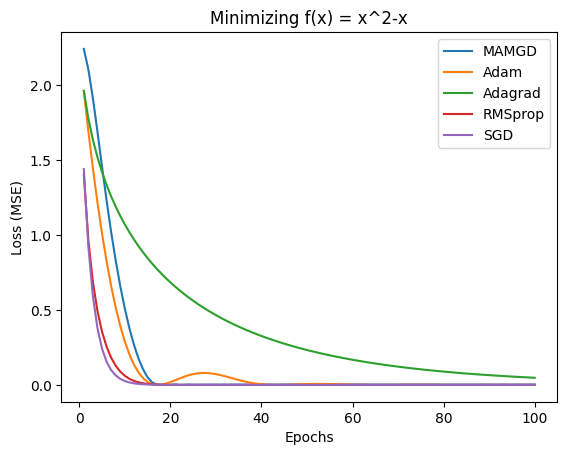

In [17]:
def test_minimization():

  MAMGD0 = []
  Adam = []
  Adagrad = []
  RMSprop = []
  SGD = []

  for N in range(1, 101):

    x = tf.Variable(-1.0)
    y = lambda: x ** 2 - x

    opt = MAMGD(learning_rate=0.1, k=0.1)
    for n in range(N):
      opt.minimize(y, [x])
    MAMGD0.append((0.5 - x) ** 2)

    x = tf.Variable(-1.0)
    y = lambda: x ** 2 - x

    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    for n in range(N):
      opt.minimize(y, [x])
    Adam.append((0.5 - x) ** 2)

    x = tf.Variable(-1.0)
    y = lambda: x ** 2 - x

    opt = tf.keras.optimizers.Adagrad(learning_rate=0.1)
    for n in range(N):
      opt.minimize(y, [x])
    Adagrad.append((0.5 - x) ** 2)

    x = tf.Variable(-1.0)
    y = lambda: x ** 2 - x

    opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
    for n in range(N):
      opt.minimize(y, [x])
    RMSprop.append((0.5 - x) ** 2)

    x = tf.Variable(-1.0)
    y = lambda: x ** 2 - x

    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    for n in range(N):
      opt.minimize(y, [x])
    SGD.append((0.5 - x) ** 2)

  plt.plot(np.arange(1, 101), MAMGD0, label="MAMGD")
  plt.plot(np.arange(1, 101), Adam, label="Adam")
  plt.plot(np.arange(1, 101), Adagrad, label="Adagrad")
  plt.plot(np.arange(1, 101), RMSprop, label="RMSprop")
  plt.plot(np.arange(1, 101), SGD, label="SGD")

  plt.title("Minimizing f(x) = x^2-x")
  plt.xlabel("Epochs")
  plt.ylabel("Loss (MSE)")
  plt.legend()
  plt.show()

test_minimization()

## Spherical function minimization tests

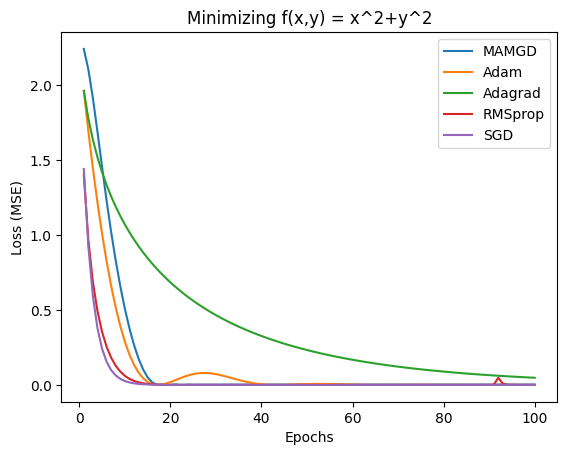

In [ ]:
def test_multiminimization():

  MAMGD0 = []
  Adam = []
  Adagrad = []
  RMSprop = []
  SGD = []

  for N in range(1, 101):

    x = tf.Variable(-1.5)
    y = tf.Variable(-1.5)
    z = lambda: x ** 2 + y ** 2

    opt = MAMGD(learning_rate=0.1, k=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    MAMGD0.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(-1.5)
    y = tf.Variable(-1.5)
    z = lambda: x ** 2 + y ** 2

    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adam.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(-1.5)
    y = tf.Variable(-1.5)
    z = lambda: x ** 2 + y ** 2

    opt = tf.keras.optimizers.Adagrad(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adagrad.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(-1.5)
    y = tf.Variable(-1.5)
    z = lambda: x ** 2 + y ** 2

    opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    RMSprop.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(-1.5)
    y = tf.Variable(-1.5)
    z = lambda: x ** 2 + y ** 2

    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    SGD.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

  plt.plot(np.arange(1, 101), MAMGD0, label="MAMGD")
  plt.plot(np.arange(1, 101), Adam, label="Adam")
  plt.plot(np.arange(1, 101), Adagrad, label="Adagrad")
  plt.plot(np.arange(1, 101), RMSprop, label="RMSprop")
  plt.plot(np.arange(1, 101), SGD, label="SGD")

  plt.title("Minimizing f(x,y) = x^2+y^2")
  plt.xlabel("Epochs")
  plt.ylabel("Loss (MSE)")
  plt.legend()
  plt.show()

test_multiminimization()

## Three-hump camel function minimization test

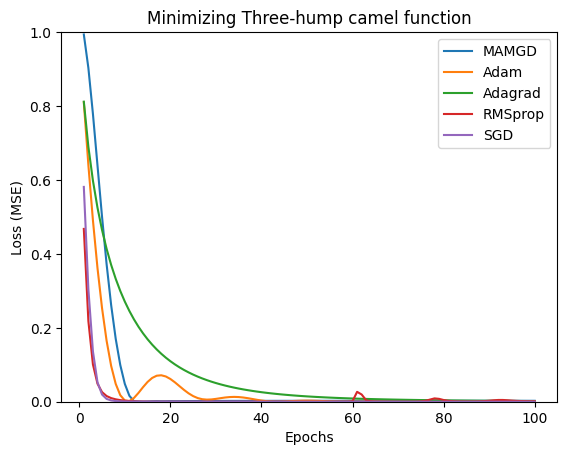

In [ ]:
def test_three_hump_camel_function():

  MAMGD0 = []
  Adam = []
  Adagrad = []
  RMSprop = []
  SGD = []

  for N in range(1,101):

    x = tf.Variable(1.0)
    y = tf.Variable(1.0)
    z = lambda: 2 * x ** 2 - 1.05 * x ** 4 + (x ** 6) / 6 + x * y + y ** 2

    opt = MAMGD(learning_rate=0.1, k=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    MAMGD0.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(1.0)
    y = tf.Variable(1.0)
    z = lambda: 2 * x ** 2 - 1.05 * x ** 4 + (x ** 6) / 6 + x * y + y ** 2

    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adam.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(1.0)
    y = tf.Variable(1.0)
    z = lambda: 2 * x ** 2 - 1.05 * x ** 4 + (x ** 6) / 6 + x * y + y ** 2

    opt = tf.keras.optimizers.Adagrad(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adagrad.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(1.0)
    y = tf.Variable(1.0)
    z = lambda: 2 * x ** 2 - 1.05 * x ** 4 + (x ** 6) / 6 + x * y + y ** 2

    opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    RMSprop.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(1.0)
    y = tf.Variable(1.0)
    z = lambda: 2 * x ** 2 - 1.05 * x ** 4 + (x ** 6) / 6 + x * y + y ** 2

    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    SGD.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

  plt.plot(np.arange(1, 101), MAMGD0, label="MAMGD")
  plt.plot(np.arange(1, 101), Adam, label="Adam")
  plt.plot(np.arange(1, 101), Adagrad, label="Adagrad")
  plt.plot(np.arange(1, 101), RMSprop, label="RMSprop")
  plt.plot(np.arange(1, 101), SGD, label="SGD")

  plt.ylim(0,1)
  plt.title("Minimizing Three-hump camel function")
  plt.xlabel("Epochs")
  plt.ylabel("Loss (MSE)")
  plt.legend()
  plt.show()

test_three_hump_camel_function()

## Matyas function minimization test

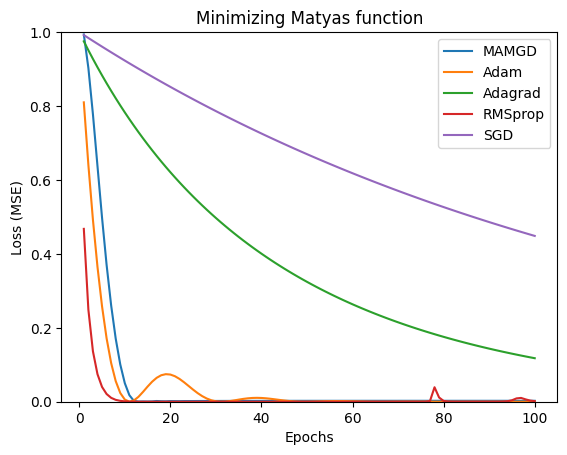

In [ ]:
def test_matyas_function():

  MAMGD0 = []
  Adam = []
  Adagrad = []
  RMSprop = []
  SGD = []

  for N in range(1,101):

    x = tf.Variable(-1.0)
    y = tf.Variable(-1.0)
    z = lambda: 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y

    opt = MAMGD(learning_rate=0.1, k=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    MAMGD0.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(-1.0)
    y = tf.Variable(-1.0)
    z = lambda: 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y

    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adam.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(-1.0)
    y = tf.Variable(-1.0)
    z = lambda: 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y

    opt = tf.keras.optimizers.Adagrad(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adagrad.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(-1.0)
    y = tf.Variable(-1.0)
    z = lambda: 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y

    opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    RMSprop.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

    x = tf.Variable(-1.0)
    y = tf.Variable(-1.0)
    z = lambda: 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y

    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    SGD.append(((0 - x) ** 2 + (0 - y) ** 2) / 2)

  plt.plot(np.arange(1, 101), MAMGD0, label="MAMGD")
  plt.plot(np.arange(1, 101), Adam, label="Adam")
  plt.plot(np.arange(1, 101), Adagrad, label="Adagrad")
  plt.plot(np.arange(1, 101), RMSprop, label="RMSprop")
  plt.plot(np.arange(1, 101), SGD, label="SGD")

  plt.ylim(0,1)
  plt.title("Minimizing Matyas function")
  plt.xlabel("Epochs")
  plt.ylabel("Loss (MSE)")
  plt.legend()
  plt.show()

test_matyas_function()

## Booth function minimization test

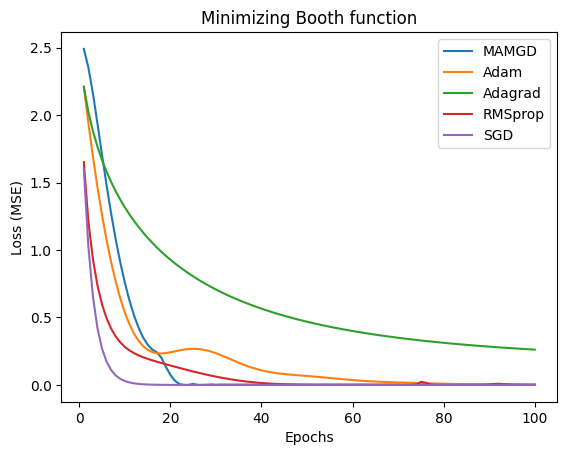

In [ ]:
def test_booth_function():

  MAMGD0 = []
  Adam = []
  Adagrad = []
  RMSprop = []
  SGD = []

  for N in range(1,101):

    x = tf.Variable(0.0)
    y = tf.Variable(1.0)
    z = lambda: (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2

    opt = MAMGD(learning_rate=0.1, k=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    MAMGD0.append(((1 - x) ** 2 + (3 - y) ** 2) / 2)

    x = tf.Variable(0.0)
    y = tf.Variable(1.0)
    z = lambda: (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2

    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adam.append(((1 -x ) ** 2 + (3 - y) ** 2) / 2)

    x = tf.Variable(0.0)
    y = tf.Variable(1.0)
    z = lambda: (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2

    opt = tf.keras.optimizers.Adagrad(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adagrad.append(((1 - x) ** 2 + (3 - y) ** 2) / 2)

    x = tf.Variable(0.0)
    y = tf.Variable(1.0)
    z = lambda: (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2

    opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    RMSprop.append(((1 - x) ** 2 + (3 - y) ** 2) / 2)

    x = tf.Variable(0.0)
    y = tf.Variable(1.0)
    z = lambda: (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2

    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    SGD.append(((1 - x) ** 2 + (3 - y) ** 2) / 2)

  plt.plot(np.arange(1,101),MAMGD0,label="MAMGD")
  plt.plot(np.arange(1,101),Adam,label="Adam")
  plt.plot(np.arange(1,101),Adagrad,label="Adagrad")
  plt.plot(np.arange(1,101),RMSprop,label="RMSprop")
  plt.plot(np.arange(1,101),SGD,label="SGD")

  plt.title("Minimizing Booth function")
  plt.xlabel("Epochs")
  plt.ylabel("Loss (MSE)")
  plt.legend()
  plt.show()

test_booth_function()

## Himmelblaus function minimization test

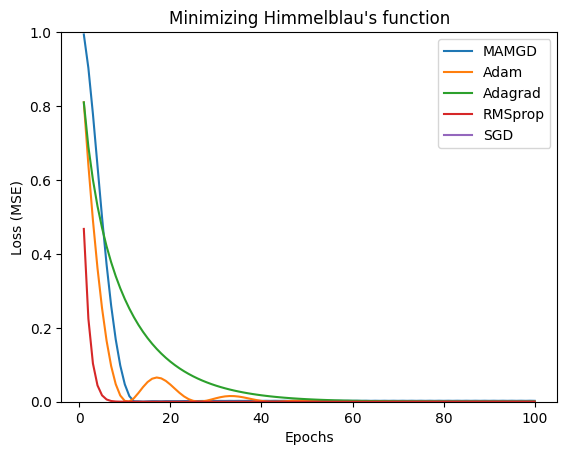

In [ ]:
def test_himmelblaus_function():

  MAMGD0 = []
  Adam = []
  Adagrad = []
  RMSprop = []
  SGD = []

  for N in range(1, 101):

    x = tf.Variable(2.0)
    y = tf.Variable(1.0)
    z = lambda: (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2

    opt = MAMGD(learning_rate=0.1, k=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    MAMGD0.append(((3 - x) ** 2 + (2 - y) ** 2) / 2)

    x = tf.Variable(2.0)
    y = tf.Variable(1.0)
    z = lambda: (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2

    opt = tf.keras.optimizers.Adam(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adam.append(((3 - x) ** 2 + (2 - y) ** 2) / 2)

    x = tf.Variable(2.0)
    y = tf.Variable(1.0)
    z = lambda: (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2

    opt = tf.keras.optimizers.Adagrad(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    Adagrad.append(((3 - x) ** 2 + (2 - y) ** 2) / 2)

    x = tf.Variable(2.0)
    y = tf.Variable(1.0)
    z = lambda: (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2

    opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    RMSprop.append(((3 - x) ** 2 + (2 - y) ** 2) / 2)

    x = tf.Variable(2.0)
    y = tf.Variable(1.0)
    z = lambda: (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2

    opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    for n in range(N):
      opt.minimize(z, [x, y])
    SGD.append(((3 - x) ** 2 + (2 - y) ** 2) / 2)

  plt.plot(np.arange(1,101),MAMGD0,label="MAMGD")
  plt.plot(np.arange(1,101),Adam,label="Adam")
  plt.plot(np.arange(1,101),Adagrad,label="Adagrad")
  plt.plot(np.arange(1,101),RMSprop,label="RMSprop")
  plt.plot(np.arange(1,101),SGD,label="SGD")
  plt.title("Minimizing Himmelblau's function")

  plt.ylim(0,1)
  plt.xlabel("Epochs")
  plt.ylabel("Loss (MSE)")
  plt.legend()
  plt.show()

test_himmelblaus_function()

# Neural Network optimization tests

## Approximation using multilayer neural network

Epoch 1/15
313/313 [==============================] - 2s 2ms/step - loss: 773.9297 - mean_squared_error: 773.9297
Epoch 2/15
313/313 [==============================] - 1s 2ms/step - loss: 102.8675 - mean_squared_error: 102.8675
Epoch 3/15
313/313 [==============================] - 1s 2ms/step - loss: 43.0081 - mean_squared_error: 43.0081
Epoch 4/15
313/313 [==============================] - 1s 2ms/step - loss: 18.2235 - mean_squared_error: 18.2235
Epoch 5/15
313/313 [==============================] - 1s 2ms/step - loss: 8.7023 - mean_squared_error: 8.7023
Epoch 6/15
313/313 [==============================] - 1s 2ms/step - loss: 3.3564 - mean_squared_error: 3.3564
Epoch 7/15
313/313 [==============================] - 1s 2ms/step - loss: 1.1289 - mean_squared_error: 1.1289
Epoch 8/15
313/313 [==============================] - 1s 3ms/step - loss: 0.4761 - mean_squared_error: 0.4761
Epoch 9/15
313/313 [==============================] - 1s 3ms/step - loss: 0.2075 - mean_squared_error: 0.207

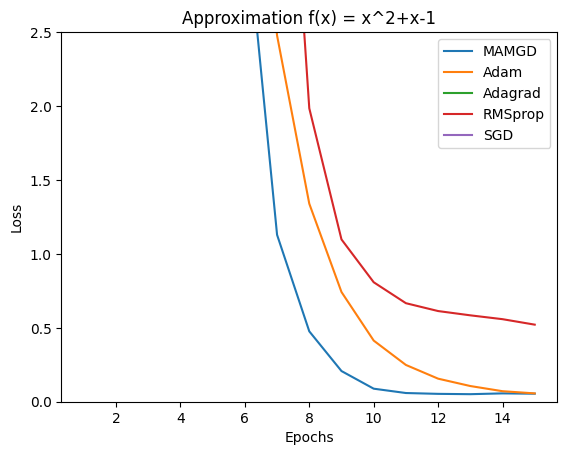

In [ ]:
x = np.linspace(-10,10,10000)
y = x ** 2 + x - 1


model_mamgd = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])

model_mamgd.compile(optimizer=MAMGD(learning_rate=0.001, beta_2=0.999, k=0.0001),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

history = model_mamgd.fit(x, y, epochs=15)
mamgd = history.history["loss"]


model_adam = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])

model_adam.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

history = model_adam.fit(x, y, epochs=15)
adam = history.history["loss"]


model_adagrad = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])

model_adagrad.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

history = model_adagrad.fit(x, y, epochs=15)
adagrad = history.history["loss"]


model_rmsprop = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])

model_rmsprop.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

history = model_rmsprop.fit(x, y, epochs=15)
rmsprop = history.history["loss"]


model_sgd = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])

model_sgd.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

history = model_sgd.fit(x, y, epochs=15)
sgd = history.history["loss"]

plt.plot(np.arange(1, 16), mamgd, label="MAMGD")
plt.plot(np.arange(1, 16), adam, label="Adam")
plt.plot(np.arange(1, 16), adagrad, label="Adagrad")
plt.plot(np.arange(1, 16), rmsprop, label="RMSprop")
plt.plot(np.arange(1, 16), sgd, label="SGD")

plt.ylim(0, 2.5)
plt.title("Approximation f(x) = x^2+x-1")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## IMDB Dataset

Epoch 1/20
30/30 [==============================] - 4s 93ms/step - loss: 0.6249 - accuracy: 0.6900 - val_loss: 0.4759 - val_accuracy: 0.8247
Epoch 2/20
30/30 [==============================] - 2s 53ms/step - loss: 0.3412 - accuracy: 0.8895 - val_loss: 0.3052 - val_accuracy: 0.8811
Epoch 3/20
30/30 [==============================] - 2s 62ms/step - loss: 0.2100 - accuracy: 0.9287 - val_loss: 0.2767 - val_accuracy: 0.8911
Epoch 4/20
30/30 [==============================] - 2s 54ms/step - loss: 0.1517 - accuracy: 0.9532 - val_loss: 0.2815 - val_accuracy: 0.8879
Epoch 5/20
30/30 [==============================] - 2s 61ms/step - loss: 0.1143 - accuracy: 0.9661 - val_loss: 0.3046 - val_accuracy: 0.8841
Epoch 6/20
30/30 [==============================] - 2s 81ms/step - loss: 0.0873 - accuracy: 0.9760 - val_loss: 0.3306 - val_accuracy: 0.8834
Epoch 7/20
30/30 [==============================] - 2s 58ms/step - loss: 0.0665 - accuracy: 0.9808 - val_loss: 0.3703 - val_accuracy: 0.8807
Epoch 8/20
30

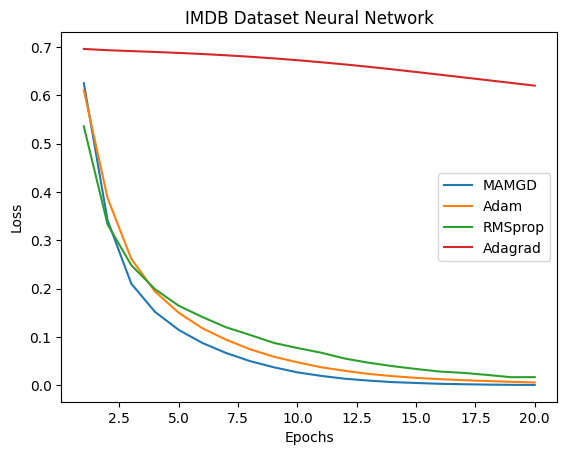

In [ ]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def vectorize_sequences(sequences, dimention=10000):
    results = np.zeros((len(sequences), dimention))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype(np.float32)
y_test = np.asarray(test_labels).astype(np.float32)

X_val = X_train[:10000]
y_val = y_train[:10000]

partial_X_train = X_train[10000:]
partial_y_train = y_train[10000:]

from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer=MAMGD(learning_rate=0.001, k=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

mamgd = history.history["loss"]

model1 = models.Sequential()
model1.add(layers.Dense(16, activation="relu", input_shape=(10000,)))
model1.add(layers.Dense(16, activation="relu"))
model1.add(layers.Dense(1, activation="sigmoid"))

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

adam = history.history["loss"]

model2 = models.Sequential()
model2.add(layers.Dense(16, activation="relu", input_shape=(10000,)))
model2.add(layers.Dense(16, activation="relu"))
model2.add(layers.Dense(1, activation="sigmoid"))

model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

rmsprop = history.history["loss"]

model3 = models.Sequential()
model3.add(layers.Dense(16, activation="relu", input_shape=(10000,)))
model3.add(layers.Dense(16, activation="relu"))
model3.add(layers.Dense(1, activation="sigmoid"))

model3.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

adagrad = history.history["loss"]

plt.plot(np.arange(1,21),mamgd,label="MAMGD")
plt.plot(np.arange(1,21),adam,label="Adam")
plt.plot(np.arange(1,21),rmsprop,label="RMSprop")
plt.plot(np.arange(1,21),adagrad,label="Adagrad")
plt.title("IMDB Dataset Neural Network")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Boston Housing Price Dataset

Epoch 1/20
404/404 [==============================] - 3s 5ms/step - loss: 370.2469 - mae: 15.9535 - val_loss: 49.5503 - val_mae: 5.0156
Epoch 2/20
404/404 [==============================] - 2s 6ms/step - loss: 30.8830 - mae: 3.9676 - val_loss: 21.1159 - val_mae: 3.1280
Epoch 3/20
404/404 [==============================] - 2s 5ms/step - loss: 18.7536 - mae: 3.0387 - val_loss: 14.1780 - val_mae: 2.6662
Epoch 4/20
404/404 [==============================] - 2s 4ms/step - loss: 14.4657 - mae: 2.7232 - val_loss: 11.4815 - val_mae: 2.3879
Epoch 5/20
404/404 [==============================] - 2s 4ms/step - loss: 12.6636 - mae: 2.5342 - val_loss: 11.2917 - val_mae: 2.4831
Epoch 6/20
404/404 [==============================] - 2s 4ms/step - loss: 12.0784 - mae: 2.4708 - val_loss: 10.2830 - val_mae: 2.3710
Epoch 7/20
404/404 [==============================] - 2s 4ms/step - loss: 11.0276 - mae: 2.3990 - val_loss: 9.5119 - val_mae: 2.2344
Epoch 8/20
404/404 [==============================] - 2s 4ms/

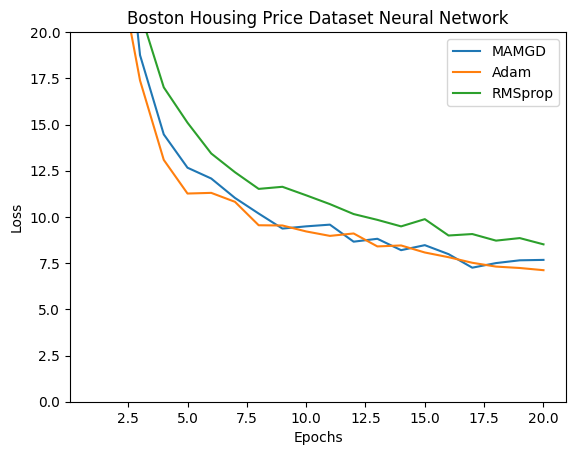

In [ ]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

num_val_samples = train_data.shape[0] // 4
num_epochs = 20
all_scores = []

val_data = train_data
val_targets = train_targets


from keras import models
from keras import layers

model = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(train_data.shape[1], )),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])

model.compile(optimizer=MAMGD(learning_rate=0.001, k=0.000001),
              loss="mse",
              metrics=["mae"])

history = model.fit(train_data, train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1)

mamgd = history.history["loss"]

model1 = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(train_data.shape[1], )),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="mse",
              metrics=["mae"])

history = model1.fit(train_data, train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1)

adam = history.history["loss"]

model2 = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(train_data.shape[1], )),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss="mse",
              metrics=["mae"])

history = model2.fit(train_data, train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1)

rmsprop = history.history["loss"]

plt.plot(np.arange(1,21),mamgd,label="MAMGD")
plt.plot(np.arange(1,21),adam,label="Adam")
plt.plot(np.arange(1,21),rmsprop,label="RMSprop")

plt.title("Boston Housing Price Dataset Neural Network")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0,20)
plt.legend()
plt.show()

Epoch 1/10
469/469 [==============================] - 9s 18ms/step - loss: 0.4426 - accuracy: 0.8824
Epoch 2/10
469/469 [==============================] - 7s 16ms/step - loss: 0.1228 - accuracy: 0.9644
Epoch 3/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0756 - accuracy: 0.9776
Epoch 4/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0518 - accuracy: 0.9837
Epoch 5/10
469/469 [==============================] - 8s 16ms/step - loss: 0.0380 - accuracy: 0.9887
Epoch 6/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0271 - accuracy: 0.9923
Epoch 7/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0204 - accuracy: 0.9940
Epoch 8/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0142 - accuracy: 0.9962
Epoch 9/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0117 - accuracy: 0.9968
Epoch 10/10
469/469 [==============================] - 8s 16ms/step - loss: 0.0089 - accura

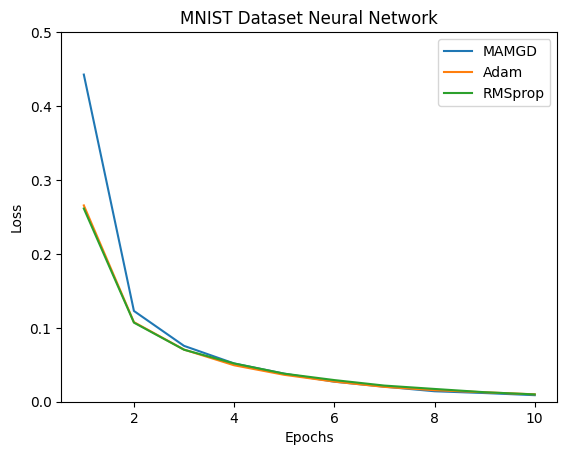

In [ ]:
from keras.datasets import mnist


(train_images, train_labels), (test_images, test_labels)  = mnist.load_data()

def flat_images(images):
    return images.reshape((images.shape[0], 28 * 28)).astype("float32") / 255

train_images = flat_images(train_images)
test_images = flat_images(test_images)

from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(512, activation="relu", input_shape=(28 * 28, )))
model.add(layers.Dense(10, activation="softmax"))

model.compile(optimizer=MAMGD(learning_rate=0.001, k=0.00001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

history = model.fit(train_images, train_labels, epochs=10, batch_size=128)

mamgd = history.history["loss"]

model1 = models.Sequential()
model1.add(layers.Dense(512, activation="relu", input_shape=(28 * 28, )))
model1.add(layers.Dense(10, activation="softmax"))

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

history = model1.fit(train_images, train_labels, epochs=10, batch_size=128)

adam = history.history["loss"]

model2 = models.Sequential()
model2.add(layers.Dense(512, activation="relu", input_shape=(28 * 28, )))
model2.add(layers.Dense(10, activation="softmax"))

model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

history = model2.fit(train_images, train_labels, epochs=10, batch_size=128)

rmsprop = history.history["loss"]

plt.plot(np.arange(1,11),mamgd,label="MAMGD")
plt.plot(np.arange(1,11),adam,label="Adam")
plt.plot(np.arange(1,11),rmsprop,label="RMSprop")

plt.title("MNIST Dataset Neural Network")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0,0.5)
plt.legend()
plt.show()

## Reuters Dataset

Epoch 1/20
16/16 [==============================] - 3s 90ms/step - loss: 3.8143 - accuracy: 0.0296 - val_loss: 3.7442 - val_accuracy: 0.1000
Epoch 2/20
16/16 [==============================] - 1s 74ms/step - loss: 3.6164 - accuracy: 0.3012 - val_loss: 3.4216 - val_accuracy: 0.4430
Epoch 3/20
16/16 [==============================] - 1s 72ms/step - loss: 3.0581 - accuracy: 0.5778 - val_loss: 2.6177 - val_accuracy: 0.6290
Epoch 4/20
16/16 [==============================] - 1s 72ms/step - loss: 2.1023 - accuracy: 0.6713 - val_loss: 1.7342 - val_accuracy: 0.6530
Epoch 5/20
16/16 [==============================] - 1s 71ms/step - loss: 1.3806 - accuracy: 0.7256 - val_loss: 1.2993 - val_accuracy: 0.7240
Epoch 6/20
16/16 [==============================] - 2s 107ms/step - loss: 1.0067 - accuracy: 0.7955 - val_loss: 1.1197 - val_accuracy: 0.7650
Epoch 7/20
16/16 [==============================] - 2s 120ms/step - loss: 0.7804 - accuracy: 0.8403 - val_loss: 1.0285 - val_accuracy: 0.7930
Epoch 8/20


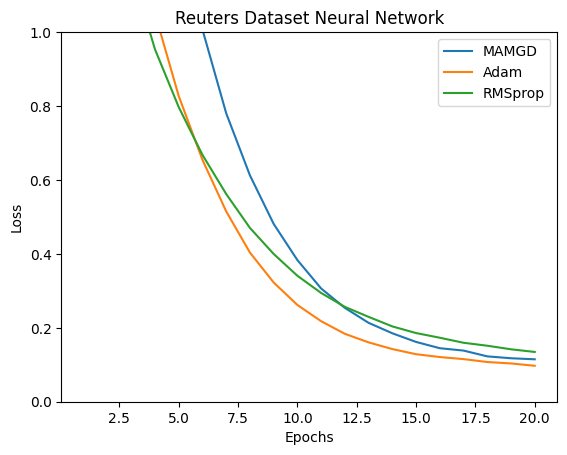

In [ ]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

def vectorize_sequences(sequences, dimention=10000):
    results = np.zeros((len(sequences), dimention))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

def to_one_hot(labels, dimention=46):
    results = np.zeros((len(labels), dimention))
    for i, l in enumerate(labels):
        results[i, l] = 1
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

X_val = X_train[:1000]
partial_X_train = X_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

from keras import models
from keras import layers

model = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(10000, )),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

model.compile(optimizer=MAMGD(learning_rate=0.001, k=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

mamgd = history.history["loss"]

model1 = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(10000, )),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

adam = history.history["loss"]

model2 = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(10000, )),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

model2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val))

rmsprop = history.history["loss"]

plt.plot(np.arange(1,21),mamgd,label="MAMGD")
plt.plot(np.arange(1,21),adam,label="Adam")
plt.plot(np.arange(1,21),rmsprop,label="RMSprop")

plt.title("Reuters Dataset Neural Network")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0,1)
plt.legend()
plt.show()